In [2]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 4.6 MB/s eta 0:00:00


In [3]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00


In [5]:
!pip install google-api-python-client

In [6]:
# For Fetching Comments
from googleapiclient.discovery import build
# For filtering comments
import re
# For filtering comments with just emojis
import emoji
# Analyze the sentiments of the comment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# For visualization
import matplotlib.pyplot as plt

In [16]:
import re
from googleapiclient.discovery import build

# Replace with your API key
API_KEY = 'AI............'  # Put in your API Key

# Function to extract video ID from YouTube URL
def extract_video_id(url):
    regex = r"(?:v=|\/)([0-9A-Za-z_-]{11}).*"
    match = re.search(regex, url)
    return match.group(1) if match else None

# Build a service object for interacting with the YouTube Data API
youtube = build('youtube', 'v3', developerKey=API_KEY)

def get_video_details(video_id):
    try:
        video_response = youtube.videos().list(
            part='snippet',
            id=video_id
        ).execute()

        # Print the entire response for debugging
        print("API Response: ", video_response)

        # Check if response contains items
        if not video_response['items']:
            print("No items found in the response.")
            return None

        # Splitting the response for channelID
        video_snippet = video_response['items'][0]['snippet']
        uploader_channel_id = video_snippet['channelId']
        print("Channel ID: " + uploader_channel_id)
        return uploader_channel_id

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example URL input
url = input('Enter Youtube Video URL: ')
video_id = extract_video_id(url)
print(f"Extracted video id: {video_id}")


Enter Youtube Video URL: https://youtu.be/0X0Jm8QValY?si=3J2ZZLu9lcJTsyGM
Extracted video id: 0X0Jm8QValY


In [17]:
# Get video details
uploader_channel_id = get_video_details(video_id)
if uploader_channel_id:
    print("Fetching Comments...")
    comments = []
    nextPageToken = None

    while len(comments) < 600:
        try:
            request = youtube.commentThreads().list(
                part='snippet',
                videoId=video_id,
                maxResults=100,  # You can fetch up to 100 comments per request
                pageToken=nextPageToken
            )
            response = request.execute()

            for item in response['items']:
                comment = item['snippet']['topLevelComment']['snippet']
                # Check if the comment is not from the video uploader
                if comment['authorChannelId']['value'] != uploader_channel_id:
                    comments.append(comment['textDisplay'])

            nextPageToken = response.get('nextPageToken')
            if not nextPageToken:
                break
        except Exception as e:
            print(f"An error occurred while fetching comments: {e}")
            break

    # Print the first 5 comments
    for comment in comments[:5]:
        print(comment)
else:
    print("Could not fetch video details, terminating the script.")

API Response:  {'kind': 'youtube#videoListResponse', 'etag': 'nLv67nZhSlJQmFwEJFgVw_v6THY', 'items': [{'kind': 'youtube#video', 'etag': 'mzhrnK7S3Qf8bTSIzvIsEQZZa08', 'id': '0X0Jm8QValY', 'snippet': {'publishedAt': '2023-10-02T23:08:40Z', 'channelId': 'UCBJycsmduvYEL83R_U4JriQ', 'title': 'iPhone 15 Review: Welcome to the Club!', 'description': 'iPhone 15 is not new. But that doesn\'t mean it isn\'t good.\n\nMKBHD Merch: http://shop.MKBHD.com\n\nTech I\'m using right now: https://www.amazon.com/shop/MKBHD\n\nOutro track: http://youtube.com/20syl\nPlaylist of MKBHD Intro music: https://goo.gl/B3AWV5\n\nPhone provided by Apple for review.\n\n0:00 Intro\n0:59 "All new" design\n3:04 Let\'s get real about 60Hz\n6:08 Performance and Heat/Battery\n7:24 USB-C \n8:09 Things that are actually new\n10:11 Underrated camera upgrade\n12:26 Verdict\n\n~\nhttp://twitter.com/MKBHD\nhttp://instagram.com/MKBHD\nhttp://facebook.com/MKBHD', 'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/0X0Jm8QVa

In [21]:
# Filter relevant comments
hyperlink_pattern = re.compile(
           r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

threshold_ratio = 0.65

relevant_comments = []

# Inside your loop that processes comments
for comment_text in comments:
      comment_text = comment_text.lower().strip()

      emojis = emoji.emoji_count(comment_text)

      # Count text characters (excluding spaces)
      text_characters = len(re.sub(r'\s', '', comment_text))

      if (any(char.isalnum() for char in comment_text)) and not hyperlink_pattern.search(comment_text):
            if emojis == 0 or (text_characters / (text_characters + emojis)) > threshold_ratio:
                relevant_comments.append(comment_text)

# Print the relevant comments
for comment in relevant_comments[:5]:
        print(comment)
else:
    print("Could not fetch video details, terminating the script.")

i wanted to ask if its okay to use samsung 25 watt adapter to charge iphone 15 ? will it cause any issue with iphones battery life or any other issues?
which iphone is good to buy for now
marques ur aspect ratio doesnt fit within in the iphone screen anymore the dynamic island bleeds into itttty
ill get this phone in about 4-5 years
what weather widget is that?
Could not fetch video details, terminating the script.


In [25]:
# Save relevant comments to file
with open("ytcomments.txt", 'w', encoding='utf-8') as f:
    for comment in relevant_comments:
        f.write(comment + "\n")

print("Comments stored successfully!")

Comments stored successfully!


In [28]:
def sentiment_scores(comment, polarity):
    # Creating a SentimentIntensityAnalyzer object.
    sentiment_object = SentimentIntensityAnalyzer()

    sentiment_dict = sentiment_object.polarity_scores(comment)
    polarity.append(sentiment_dict['compound'])

    return polarity

polarity = []
positive_comments = []
negative_comments = []
neutral_comments = []

# Read comments from file
with open("ytcomments.txt", 'r', encoding='utf-8') as f:
    comments = f.readlines()

print("Analyzing Comments...")

# Perform sentiment analysis for each comment
for index, comment in enumerate(comments):
    polarity = sentiment_scores(comment, polarity)

    # Classify comments based on sentiment score
    if polarity[-1] > 0.05:
        positive_comments.append(comment)
    elif polarity[-1] < -0.05:
        negative_comments.append(comment)
    else:
        neutral_comments.append(comment)

# Print the first 5 polarity scores
print("Polarity Scores (First 5):", polarity[:5])

# Print some statistics
print(f"Total Comments: {len(comments)}")
print(f"Positive Comments: {len(positive_comments)}")
print(f"Negative Comments: {len(negative_comments)}")
print(f"Neutral Comments: {len(neutral_comments)}")

Analyzing Comments...
Polarity Scores (First 5): [0.3094, 0.4404, 0.1255, -0.4215, 0.0]
Total Comments: 567
Positive Comments: 313
Negative Comments: 93
Neutral Comments: 161


In [30]:
avg_polarity = sum(polarity) / len(polarity)
print("Average Polarity:", avg_polarity)

if avg_polarity > 0.05:
    print("The Video has got a Positive response")
elif avg_polarity < -0.05:
    print("The Video has got a Negative response")
else:
    print("The Video has got a Neutral response")

# Find comment with the most positive sentiment
max_positive_index = polarity.index(max(polarity))
max_positive_comment = comments[max_positive_index].strip()
max_positive_score = polarity[max_positive_index]
max_positive_length = len(max_positive_comment)

print("The comment with the most positive sentiment:", max_positive_comment, "with score", max_positive_score, "and length", max_positive_length)

# Find comment with the most negative sentiment
min_negative_index = polarity.index(min(polarity))
min_negative_comment = comments[min_negative_index].strip()
min_negative_score = polarity[min_negative_index]
min_negative_length = len(min_negative_comment)

print("The comment with the most negative sentiment:", min_negative_comment, "with score", min_negative_score, "and length", min_negative_length)


Average Polarity: 0.23820211640211608
The Video has got a Positive response
The comment with the most positive sentiment: you know the ios you never notice na 60 hrts , i used it it very smooth ,important to me watching. movvies n youtube important to me the accurate color of the screen , that what i pay for , iphone is the best  screen with its true tone , and the camera superb , i don’t like android china phone , if you want that go , look all the hollywood celebrities using iphone ios ,,don’t base on the stupid 130 hrts , it consume more batery to  drain faster ,,if you have money this is a solid phone , waistng of time echoing your review 😂😂😂😂😂😂 with score 0.9834 and length 535
The comment with the most negative sentiment: apart from the fact that the apple&#39;s os has always been shit in literally all of their devices, clearly including the rather yearly &quot;updated&quot; iphone, it&#39;s simply no surprise. the restrictive nature of apple is obvious in their os and you simply 

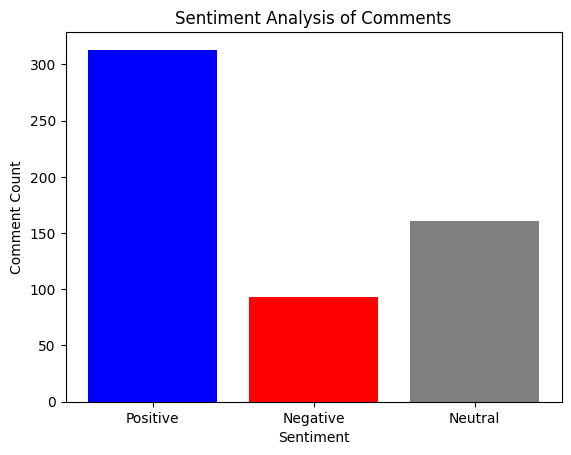

In [31]:
# Counts of each sentiment category
positive_count = len(positive_comments)
negative_count = len(negative_comments)
neutral_count = len(neutral_comments)

# Labels and data for Bar chart
labels = ['Positive', 'Negative', 'Neutral']
comment_counts = [positive_count, negative_count, neutral_count]

# Creating bar chart
plt.bar(labels, comment_counts, color=['blue', 'red', 'grey'])

# Adding labels and title to the plot
plt.xlabel('Sentiment')
plt.ylabel('Comment Count')
plt.title('Sentiment Analysis of Comments')

# Displaying the chart
plt.show()

([<matplotlib.patches.Wedge at 0x7f70b0fb9330>,
 [Text(-0.5605224591962116, -0.946474813577536, 'Positive'),
  Text(1.0886055709037217, 0.15791741828367833, 'Negative'),
  Text(0.021330292060992604, 1.0997931708464974, 'Neutral')],
 [Text(-0.3057395231979335, -0.5162589892241105, '55.2%'),
  Text(0.5937848568565754, 0.08613677360927909, '16.4%'),
  Text(0.011634704760541419, 0.5998871840980894, '28.4%')])

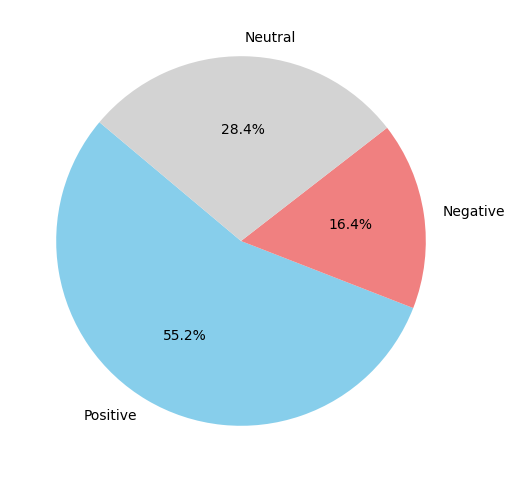

In [32]:
# Counts of each sentiment category
positive_count = len(positive_comments)
negative_count = len(negative_comments)
neutral_count = len(neutral_comments)

# Labels and data for Pie chart
labels = ['Positive', 'Negative', 'Neutral']
comment_counts = [positive_count, negative_count, neutral_count]

plt.figure(figsize=(10, 6))  # Setting size of the figure

# Plotting pie chart
plt.pie(comment_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral', 'lightgrey'])